# Visualisation Grad-CAM pour ResNet50

Ce notebook utilise Grad-CAM pour visualiser les zones importantes sur les radiographies COVID.


In [1]:
import sys
import torch
import torch.nn.functional as F
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

sys.path.append('../src/features')
from model_utils import load_model
from training_config import *

print("Imports OK")


Imports OK


In [2]:
# Charger le modèle
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = Path('../models/') / MODEL_CHECKPOINT_PATH

model = load_model(
    model_choice=MODEL_CHOICE,
    num_classes=NUM_CLASSES,
    checkpoint_path=checkpoint_path,
    device=device,
    transfer_mode=TRANSFER_MODE,
)
model.eval()
print("Modele charge")


  Mode: Fine-tuning sélectif (couches gelées: ['conv1', 'bn1', 'layer1'])

 Modèle resnet50 créé
   Paramètres totaux: 23,505,858
   Paramètres entraînables: 18,987,010 (80.8%)
   Paramètres gelés: 4,518,848 (19.2%)
 Format détecté: state_dict direct
 Modèle chargé depuis '../models/best_model_resnet50-marouane.pth'
 Modèle déplacé sur mps
   Paramètres totaux: 23,505,858
   Paramètres entraînables: 18,987,010
Modele charge


In [3]:
# Configuration Grad-CAM
# Pour ResNet, on utilise généralement layer4 (dernière couche convolutive)
target_layers = [model.layer4[-1]]

# Créer l'objet GradCAM
# Note: use_cuda n'est plus nécessaire, le modèle doit être sur le bon device
cam = GradCAM(model=model, target_layers=target_layers)

print(f"Grad-CAM configure avec la couche: {target_layers[0]}")
print(f"Device utilise: {device}")


Grad-CAM configure avec la couche: Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)
Device utilise: mps


In [4]:
def visualize_gradcam(image_path, model, cam, device, target_class=None):
    """
    Visualise Grad-CAM pour une image donnée.
    
    Args:
        image_path: Chemin vers l'image
        model: Modèle PyTorch
        cam: Objet GradCAM
        device: Device (cpu/cuda/mps)
        target_class: Classe cible pour Grad-CAM (None = classe prédite)
    """
    # Charger et préprocesser l'image
    img = Image.open(image_path).convert('L').resize((299, 299))
    img_array = np.array(img, dtype=np.float32) / 255.0
    
    # Convertir en RGB pour Grad-CAM (nécessite 3 canaux)
    img_rgb = np.stack([img_array, img_array, img_array], axis=-1)
    
    # Préparer l'input pour le modèle (grayscale)
    img_tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0).float()
    img_tensor = transforms.Normalize(mean=[0.5], std=[0.5])(img_tensor)
    img_tensor = img_tensor.to(device)
    
    # Prédiction
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
    
    if BINARY_CLASSIFICATION:
        pred_class = 'COVID' if probs[1] > 0.5 else 'Non-COVID'
        pred_prob = probs[1] if probs[1] > 0.5 else probs[0]
        target_class_idx = 1 if target_class == 'COVID' or target_class is None else 0
    else:
        classes = CLASSES
        pred_idx = np.argmax(probs)
        pred_class = classes[pred_idx]
        pred_prob = probs[pred_idx]
        target_class_idx = pred_idx if target_class is None else classes.index(target_class)
    
    # Générer la carte Grad-CAM
    # Utiliser ClassifierOutputTarget pour spécifier la classe cible
    targets = [ClassifierOutputTarget(target_class_idx)]
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    # Superposer la carte sur l'image
    visualization = show_cam_on_image(img_rgb, grayscale_cam, use_rgb=True)
    
    # Afficher les résultats
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Image originale
    axes[0].imshow(img_array, cmap='gray')
    axes[0].set_title(f'Image originale\n{Path(image_path).name}')
    axes[0].axis('off')
    
    # Carte Grad-CAM
    axes[1].imshow(grayscale_cam, cmap='jet')
    axes[1].set_title('Carte Grad-CAM\n(Zones importantes)')
    axes[1].axis('off')
    
    # Superposition
    axes[2].imshow(visualization)
    axes[2].set_title(f'Superposition\nPrediction: {pred_class} ({pred_prob:.2%})')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return pred_class, pred_prob


Image selectionnee: COVID-3362.png


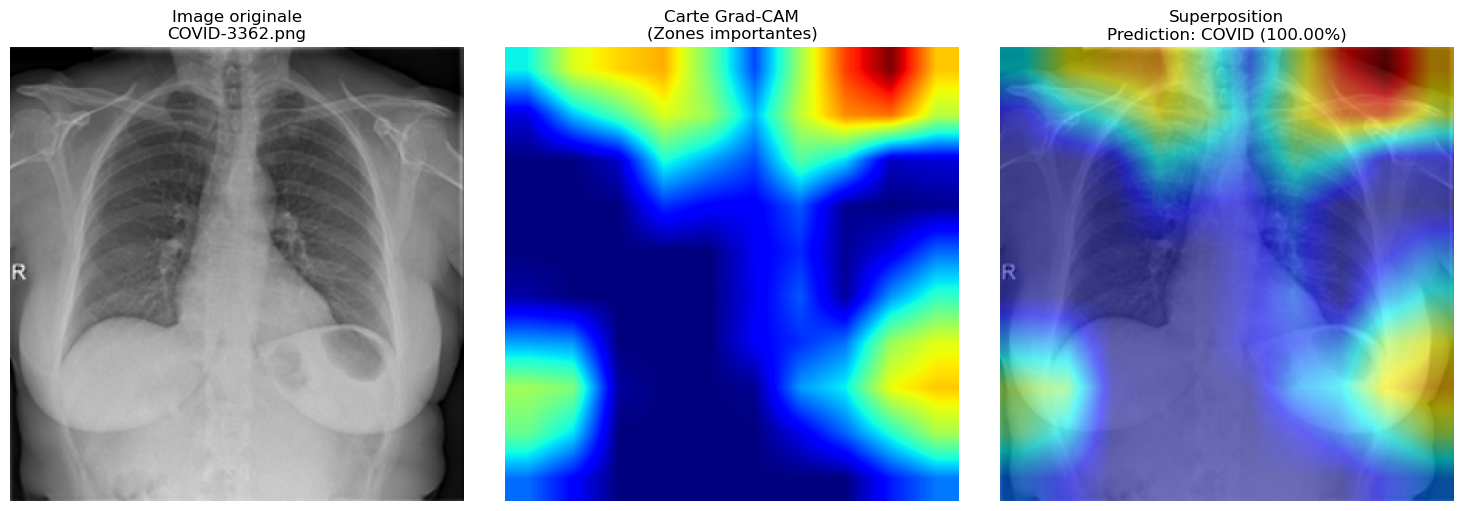


Prediction: COVID avec confiance 100.00%


In [5]:
# Exemple: Visualiser une image COVID
import random

dataset_root = DATASET_ROOT
covid_images = list((dataset_root / 'COVID' / 'images').glob('*.png'))

if covid_images:
    # Sélectionner une image aléatoirement
    image_path = random.choice(covid_images)
    print(f"Image selectionnee: {image_path.name}")
    
    # Visualiser
    pred_class, pred_prob = visualize_gradcam(image_path, model, cam, device)
    print(f"\nPrediction: {pred_class} avec confiance {pred_prob:.2%}")
else:
    print("Aucune image COVID trouvee")



Image 1/3: ds2_COVID_273.png


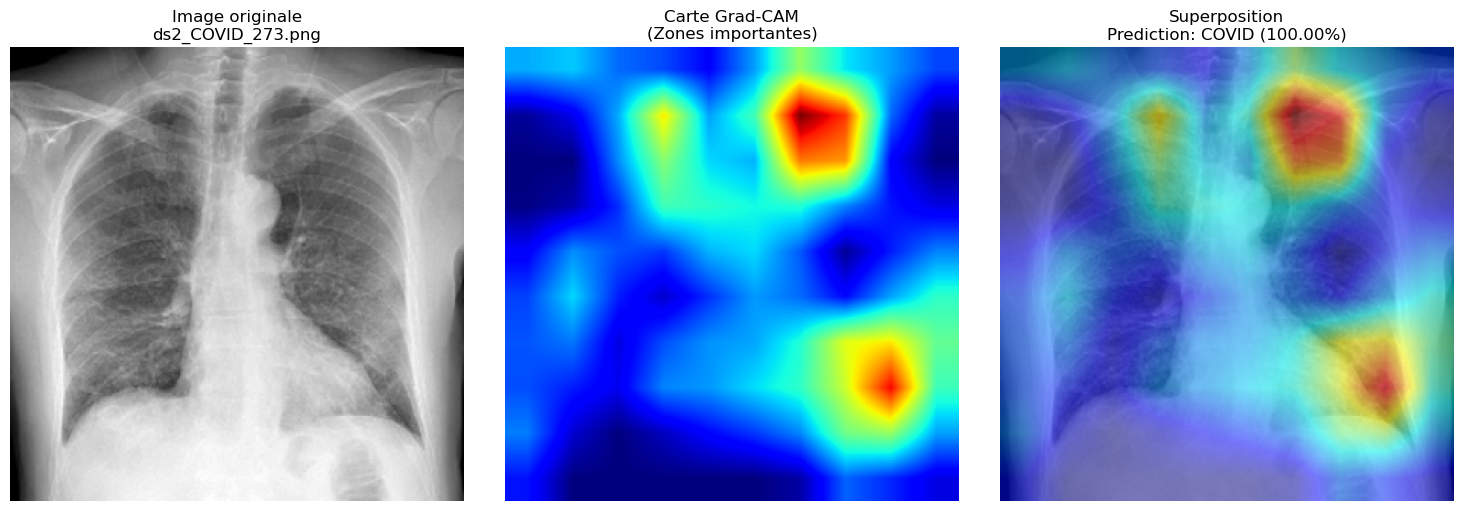

Prediction: COVID (100.00%)

Image 2/3: COVID-1.png


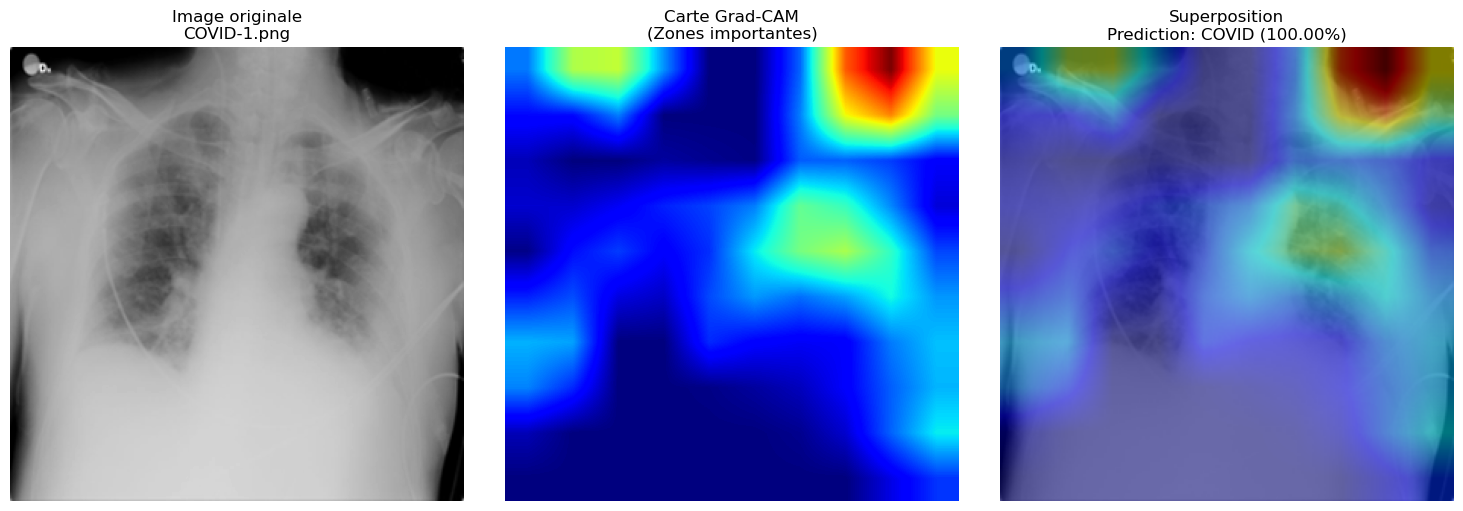

Prediction: COVID (100.00%)

Image 3/3: COVID-1175.png


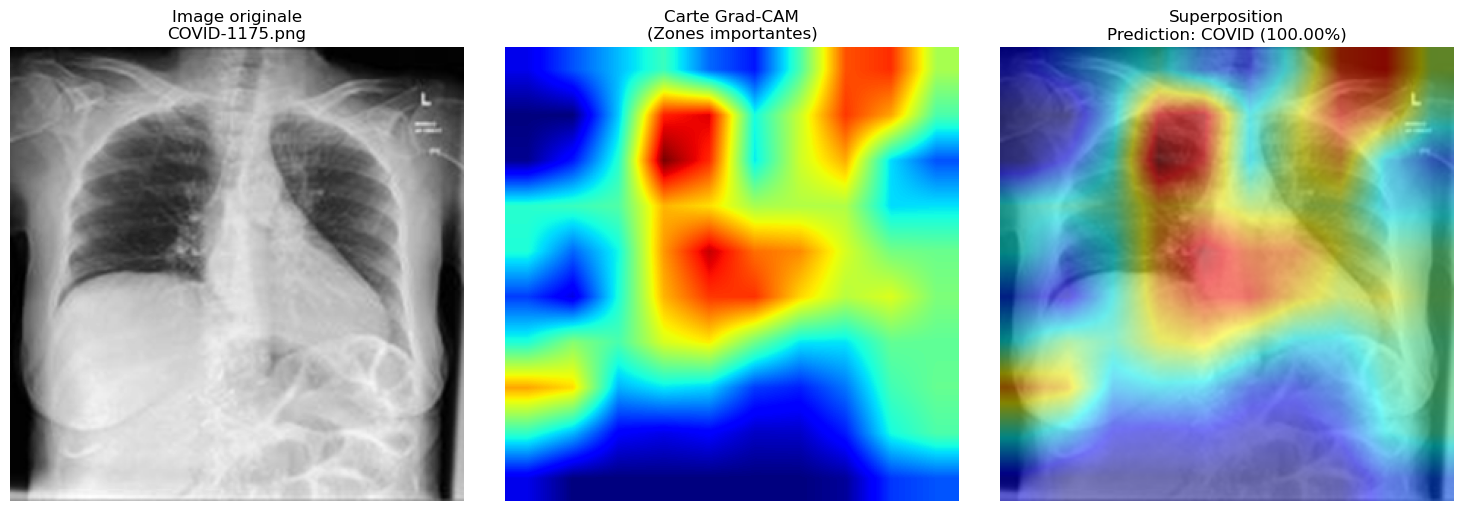

Prediction: COVID (100.00%)


In [6]:
# Visualiser plusieurs images
num_images = 3

for i in range(min(num_images, len(covid_images))):
    image_path = covid_images[i]
    print(f"\n{'='*70}")
    print(f"Image {i+1}/{num_images}: {image_path.name}")
    print(f"{'='*70}")
    
    pred_class, pred_prob = visualize_gradcam(image_path, model, cam, device)
    print(f"Prediction: {pred_class} ({pred_prob:.2%})")
